In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

In [2]:
df = pd.read_csv("TweetSentiment.csv")
df = df[['text', 'sentiment']]
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [3]:
df.isnull().sum()

text         1
sentiment    0
dtype: int64

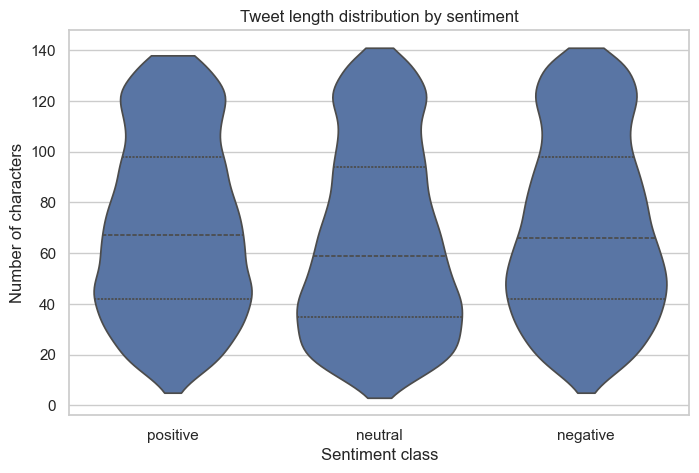

In [4]:
df["char_len"] = df["text"].str.len()

ax = sns.violinplot(
    data=df,
    x="sentiment",
    y="char_len",
    order=["positive", "neutral", "negative"],
    inner="quartile",
    cut=0
)
ax.set(
    title="Tweet length distribution by sentiment",
    xlabel="Sentiment class",
    ylabel="Number of characters"
)
plt.show()


sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64


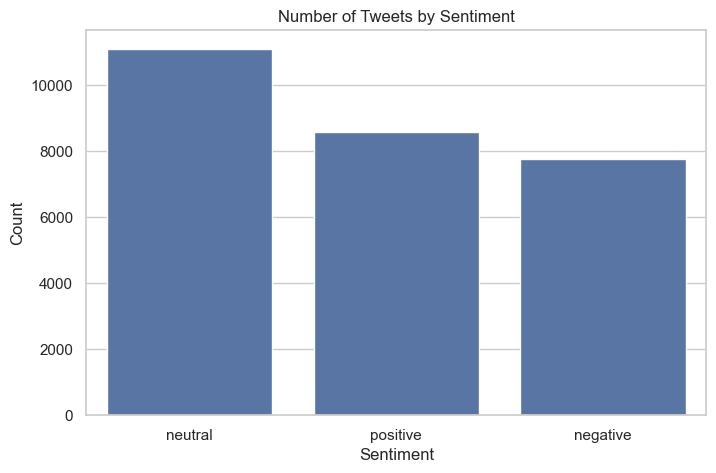

In [5]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)

sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title("Number of Tweets by Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


In [6]:
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

df['tokens'] = df['text'].astype(str).apply(tokenize)

unique_words_all = set()
unique_words_by_sentiment = {}

for sentiment in df['sentiment'].unique():
    words = df[df['sentiment'] == sentiment]['tokens'].sum()
    unique_words = set(words)
    unique_words_by_sentiment[sentiment] = unique_words
    unique_words_all.update(unique_words)
    print(f"{sentiment}: {len(unique_words)} unique words")

print(f"\nTotal unique words in the full dataset: {len(unique_words_all)}")


neutral: 15370 unique words
negative: 11715 unique words
positive: 12224 unique words

Total unique words in the full dataset: 26478


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I762691/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


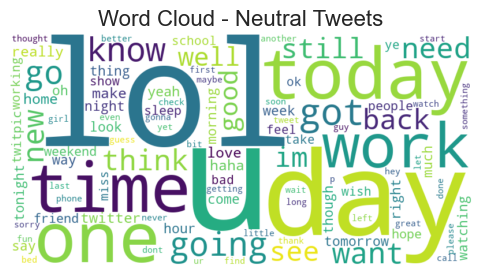

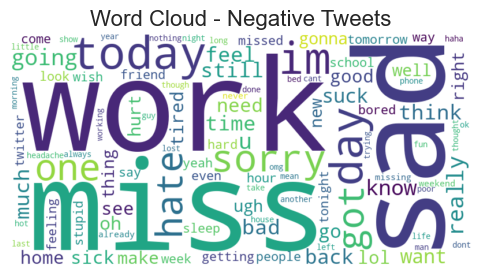

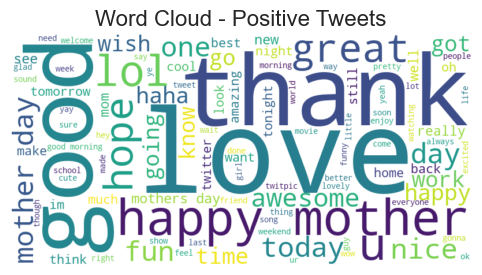

In [7]:
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
negations = {"no", "not", "nor", "don't", "didn't", "isn't", "wasn't", "aren't", 
             "won't", "wouldn't", "shouldn't", "couldn't", "can't", "doesn't", "haven't", "hadn't"}

stop_words = stop_words - negations

def clean_text(text):
    if not isinstance(text, str):
        return ""
    words = re.findall(r'\b\w+\b', text.lower())
    return ' '.join([word for word in words if word not in stop_words])

for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]
    combined_text = ' '.join(subset['text'].astype(str).apply(clean_text))

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        max_words=100
    ).generate(combined_text)

    plt.figure(figsize=(8, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {sentiment.capitalize()} Tweets", fontsize=16)
    plt.show()


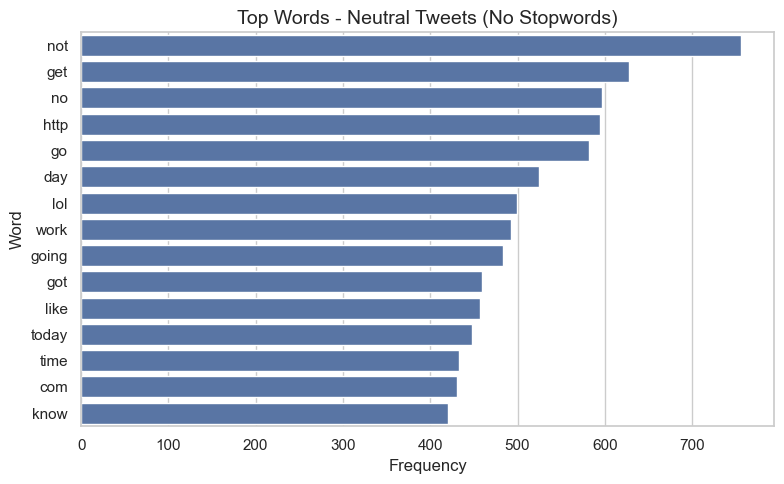

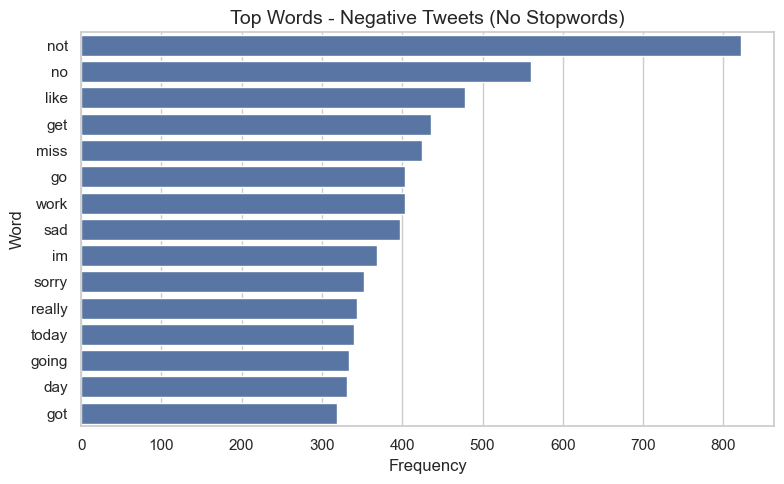

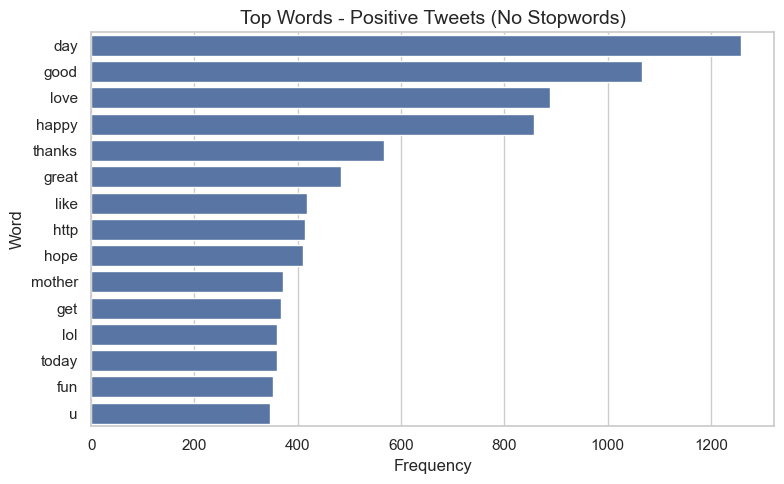

In [8]:
from collections import Counter


for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]
    
    combined_text = ' '.join(subset['text'].astype(str).apply(clean_text))
    words = combined_text.split()

    word_freq = Counter(words)
    top_words = word_freq.most_common(15)
    words, counts = zip(*top_words)

    plt.figure()
    sns.barplot(x=list(counts), y=list(words))
    plt.title(f"Top Words - {sentiment.capitalize()} Tweets (No Stopwords)", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

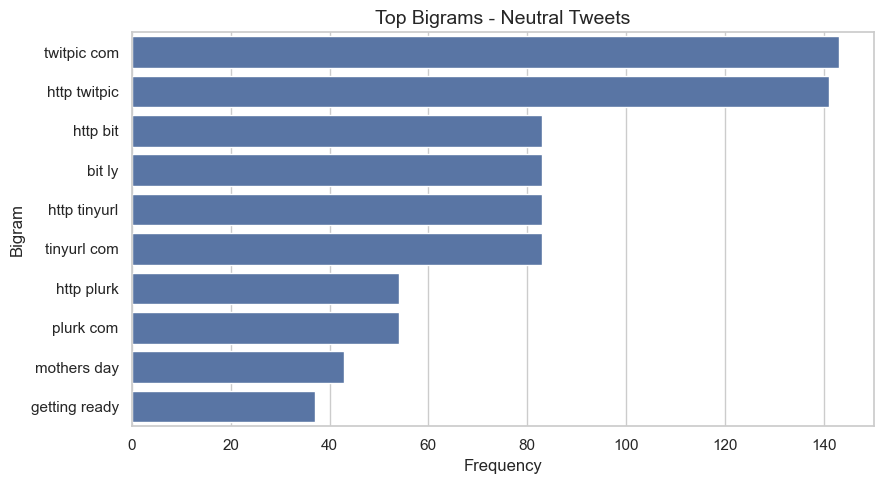

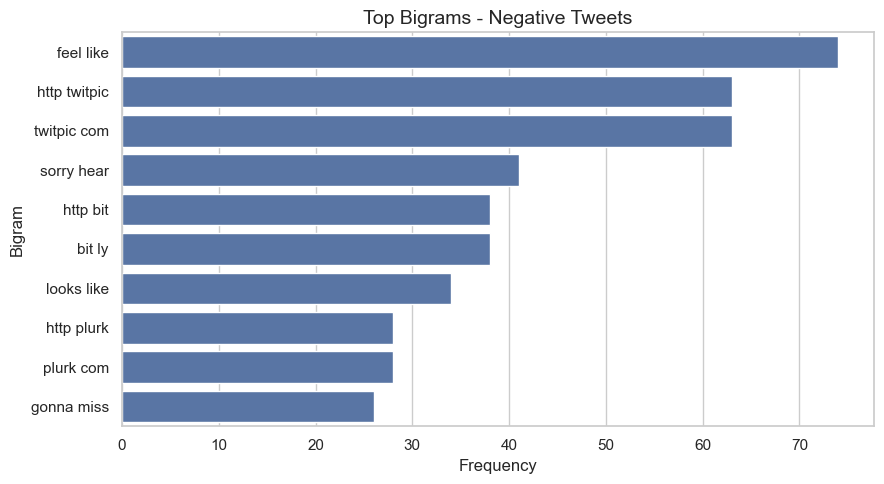

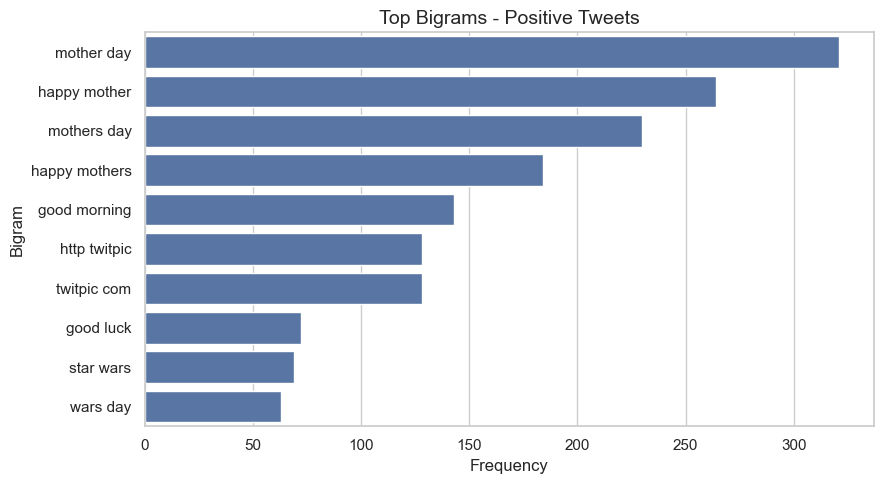

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

for sentiment in df['sentiment'].unique():
    subset = df[df['sentiment'] == sentiment]
    cleaned_texts = subset['text'].astype(str).apply(clean_text)

    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
    X = vectorizer.fit_transform(cleaned_texts)
    sum_words = X.sum(axis=0)
    
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    sorted_bigrams = sorted(word_freq, key=lambda x: x[1], reverse=True)[:10]
    
    bigrams, counts = zip(*sorted_bigrams)
    
    plt.figure(figsize=(9, 5))
    sns.barplot(x=list(counts), y=list(bigrams))
    plt.title(f"Top Bigrams - {sentiment.capitalize()} Tweets", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Bigram")
    plt.tight_layout()
    plt.show()


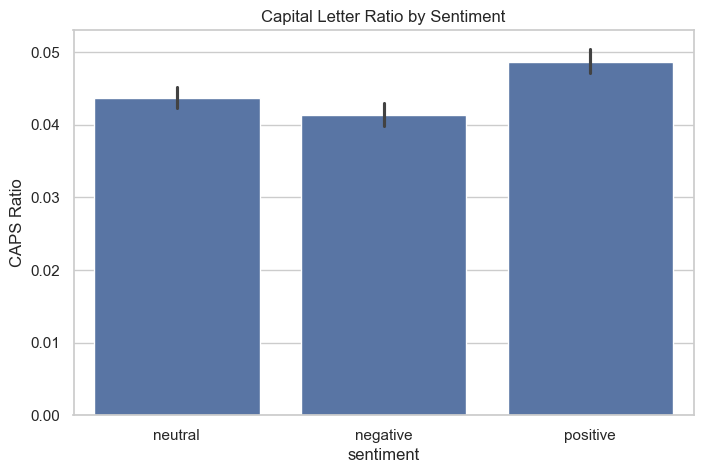

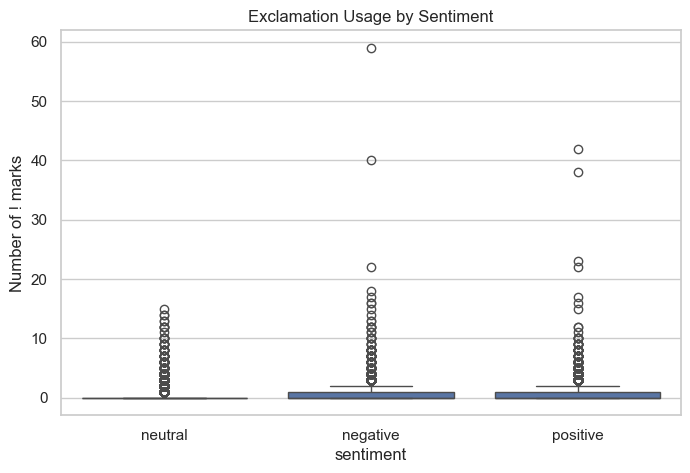

In [11]:
df['caps_ratio'] = df['text'].apply(lambda x: sum(1 for c in str(x) if c.isupper()) / len(str(x)) if len(str(x)) > 0 else 0)
df['exclams'] = df['text'].str.count('!')

sns.barplot(data=df, x='sentiment', y='caps_ratio')
plt.title("Capital Letter Ratio by Sentiment")
plt.ylabel("CAPS Ratio")
plt.show()

sns.boxplot(data=df, x='sentiment', y='exclams')
plt.title("Exclamation Usage by Sentiment")
plt.ylabel("Number of ! marks")
plt.show()
